In [1]:
%pip install -r req.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Model training & pipelines
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, cross_val_predict

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# Models
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic, WhiteKernel, ConstantKernel as C
# from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from xgboost import XGBRegressor

# Testing
import statsmodels.api as sm

# Metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [3]:
# Load the datasets
file1 = "datasets/flex_sensor_data.csv"

df1 = pd.read_csv(file1)

# Concatenate the DataFrames
df = pd.concat([df1], ignore_index=True)  # `ignore_index=True` resets the index

# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle and reset index

# Display first few rows
print(df.head())

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Check data types
print("Data types:\n", df.dtypes)

   Angle (degrees)  Resistance (kÎ©)
0              165             22.07
1              116             17.14
2              117             17.21
3              180             20.36
4              180             20.00
Missing values:
 Angle (degrees)     0
Resistance (kÎ©)    0
dtype: int64
Data types:
 Angle (degrees)       int64
Resistance (kÎ©)    float64
dtype: object


In [4]:
# Define features (X) and target variable (y)
X = df.drop(columns=['Angle (degrees)'])  # Replace 'TargetColumn' with the actual column name
y = df['Angle (degrees)']

# Split data into training and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (optional, based on sensor value range)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Training

In [5]:
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

In [6]:
# Step 1: Fit an initial OLS model
ols_model = sm.OLS(y_train, X_train_sm).fit()

# Step 2: Estimate residuals and compute weights
residuals = ols_model.resid
weights = 1 / (residuals ** 2 + 1e-8)  # Add small epsilon to avoid divide-by-zero

# Step 3: Fit WLS model
model = sm.WLS(y_train, X_train_sm, weights=weights).fit()

In [7]:
# Generate prediction object
predictions = model.get_prediction(X_test_sm)

# Get full summary frame as DataFrame
summary_df = predictions.summary_frame(alpha=0.05)

# Testing

In [8]:
y_pred = model.predict(X_test_sm)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
n, p = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"\n📊 WLS Model Evaluation:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")
print(f"Adjusted R²: {adjusted_r2:.4f}")


📊 WLS Model Evaluation:
MAE: 9.4911
MSE: 175.6335
RMSE: 13.2527
R²: 0.9331
Adjusted R²: 0.9327


In [9]:
# Get full prediction result with uncertainty
predictions = model.get_prediction(X_test_sm)
summary = predictions.summary_frame(alpha=0.05)  # 95% CI

In [20]:
X_test_df = X_test_df.reset_index(drop=True)
y_test_series = pd.Series(y_test).reset_index(drop=True)

X_test_df = pd.DataFrame(X_test, columns=X.columns)
X_test_df['y_pred'] = wls_summary['mean']
X_test_df['uncertainty'] = wls_summary['obs_ci_upper'] - wls_summary['obs_ci_lower'] # calculating uncertainity given a new prediction
X_test_df['y_true'] = y_test_series

In [22]:
X_test_df.to_csv("datasets/testing.csv", index=False)
print("✅ Saved uncertainity to 'testing.csv'")


✅ Saved uncertainity to 'testing.csv'


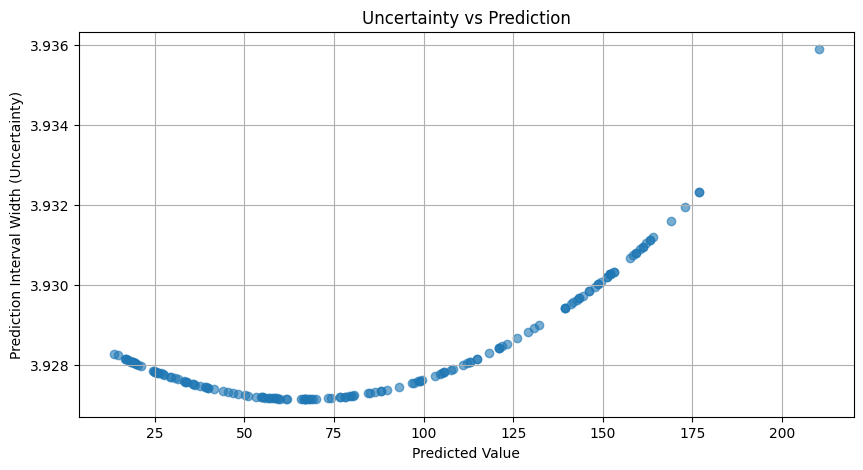

In [24]:
plt.figure(figsize=(10, 5))
plt.scatter(X_test_df['y_pred'], X_test_df['uncertainty'], alpha=0.6)
plt.xlabel("Predicted Value")
plt.ylabel("Prediction Interval Width (Uncertainty)")
plt.title("Uncertainty vs Prediction")
plt.grid(True)
plt.show()